In [29]:
!pip install tensorflow_text
import tensorflow_text as text

In [30]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [31]:
# Combine textual features into a single input text including the sentiment_analysis column
def combine_features(row):
    # Combine the text with other extracted features and sentiment_analysis as a feature
    return f"Text: {row['text']} | Objects: {row['detected_objects']} | Emotion: {row['Dominant Emotion']} | " \
           f"Race: {row['Dominant Race']} | Gender: {row['gender']} | Age Group: {row['age_group']} | " \
           f"Sentiment: {row['sentiment_analysis']}"

In [32]:
df = pd.read_csv("/kaggle/input/new-datasets-final/final_datasets_new.csv")
valid_df = pd.read_csv("/kaggle/input/new-datasets-final/new_validation.csv")

train_df = df.iloc[:7000]
test_df = df.iloc[7000:8500]

print(train_df.shape, valid_df.shape, test_df.shape)

df['combined_features'] = df.apply(combine_features, axis=1)
valid_df['combined_features'] = valid_df.apply(combine_features, axis=1)
# Apply to train_df and test_df
train_df['combined_features'] = train_df.apply(combine_features, axis=1)
test_df['combined_features'] = test_df.apply(combine_features, axis=1)

(7000, 11) (500, 11) (1500, 11)


/tmp/ipykernel_34/1028839324.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['combined_features'] = train_df.apply(combine_features, axis=1)
/tmp/ipykernel_34/1028839324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['combined_features'] = test_df.apply(combine_features, axis=1)


In [33]:
# Print one value from df['combined_features']
print(df['combined_features'].iloc[0])

# Print one value from valid_df['combined_features']
print(valid_df['combined_features'].iloc[0])

# Print one value from df['combined_features']
print(train_df['combined_features'].iloc[0])

# Print one value from valid_df['combined_features']
print(test_df['combined_features'].iloc[0])

Text: when you're feeling horny asf but your habibi is on periods let's try a goat | Objects: person | Emotion: happy | Race: middle eastern | Gender: man | Age Group: 35-44 years | Sentiment: bad
Text: white people is this a shooting range | Objects: person, person, person, sports ball, person, person, handbag, person, sports ball, skateboard, backpack, sports ball, apple | Emotion: nan | Race: nan | Gender: nan | Age Group: nan | Sentiment: bad
Text: when you're feeling horny asf but your habibi is on periods let's try a goat | Objects: person | Emotion: happy | Race: middle eastern | Gender: man | Age Group: 35-44 years | Sentiment: bad
Text: when your boss asks for the report but you went out the past few nights | Objects: person | Emotion: neutral | Race: latino hispanic | Gender: woman | Age Group: 25-34 years | Sentiment: bad


In [34]:
X_train = train_df["combined_features"]
y_train = train_df["label"]

X_valid = valid_df["combined_features"]
y_valid = valid_df["label"]

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(7000,)
(7000,)
(500,)
(500,)


In [35]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

In [36]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


In [37]:
# Classification
# Add dropout layer for regularization
drop1 = tf.keras.layers.Dropout(0.3)(pooled_output)

# Add hidden dense layers with more units and L2 regularization
hidden1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop1)
drop2 = tf.keras.layers.Dropout(0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop2)
drop3 = tf.keras.layers.Dropout(0.3)(hidden2)

# Output layer (Sigmoid for binary classification)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(drop3)

# Model creation
model = tf.keras.Model(inputs=[text_input], outputs=[output_layer])

# Model compilation with a lower learning rate for stability
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_type_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [38]:
# Define compute_metrics function
def compute_metrics(y_true, y_pred):
    # Convert probabilities to binary predictions
    preds = (y_pred > 0.5).astype(int)  # Assumes sigmoid output
    
    # Calculate precision, recall, f1 score (for binary classification)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary")
    
    # Calculate accuracy
    acc = accuracy_score(y_true, preds)
    
    # Print the computed metrics
    print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    
    # Return the metrics as a dictionary
    return {
        "accuracy": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall
    }

In [39]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_binary_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_binary_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_binary_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-7  # Lower bound on the learning rate
    )
]

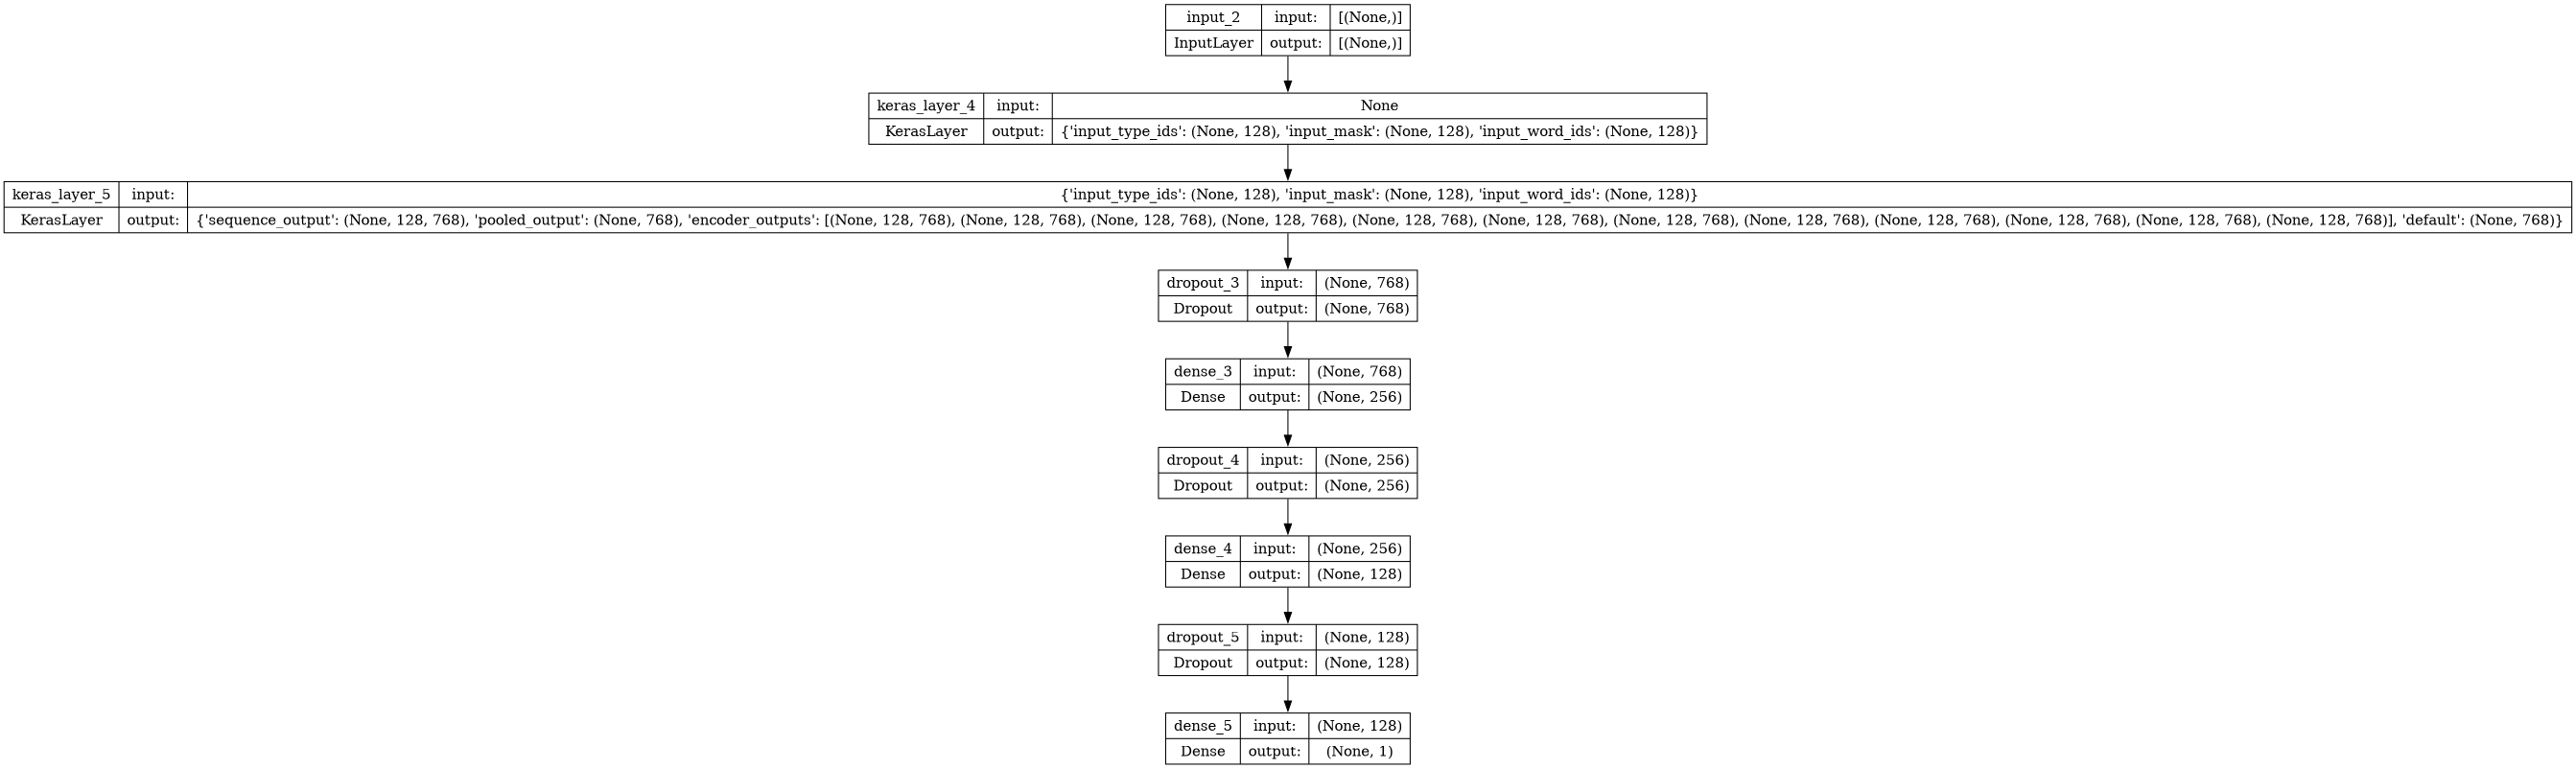

In [40]:
# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [41]:
# Train model
epochs = 10
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 6.0131 - binary_accuracy: 0.6317
Epoch 1: val_binary_accuracy improved from -inf to 0.56200, saving model to best_model.h5
219/219 [==============================] - 229s 905ms/step - loss: 6.0131 - binary_accuracy: 0.6317 - val_loss: 5.8656 - val_binary_accuracy: 0.5620 - lr: 2.0000e-05
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 5.5763 - binary_accuracy: 0.7054
Epoch 2: val_binary_accuracy did not improve from 0.56200
219/219 [==============================] - 196s 894ms/step - loss: 5.5763 - binary_accuracy: 0.7054 - val_loss: 5.6281 - val_binary_accuracy: 0.5580 - lr: 2.0000e-05
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 5.1745 - binary_accuracy: 0.7479
Epoch 3: val_binary_accuracy improved from 0.56200 to 0.57600, saving model to best_model.h5
219/219 [==============================] - 197s 901ms/step - loss: 5.1745 - binary_accuracy: 0.7479 - val_loss: 5.1475

47/47 [==============================] - 15s 332ms/step
Accuracy: 65.00%
AUC Score: 0.6970
Precision: 0.5364
Recall: 0.5694
F1 Score: 0.5524

Classification Report:
              precision    recall  f1-score   support

           0     0.7266    0.6992    0.7126       931
           1     0.5364    0.5694    0.5524       569

    accuracy                         0.6500      1500
   macro avg     0.6315    0.6343    0.6325      1500
weighted avg     0.6544    0.6500    0.6519      1500



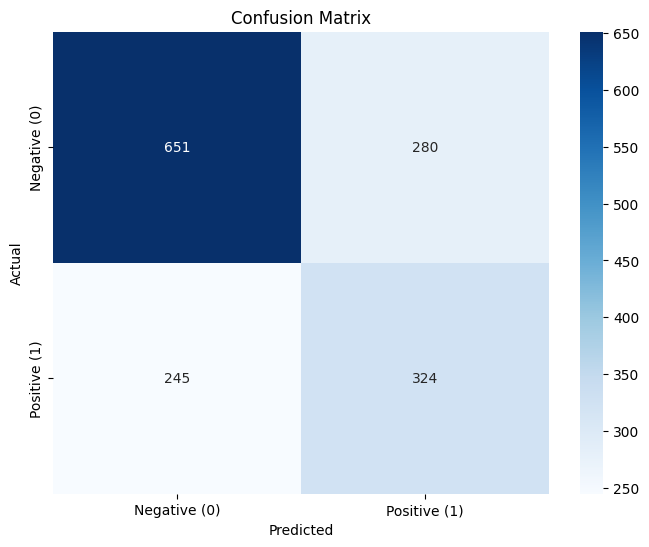

In [46]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare test data
X_test = test_df["text"]
y_test = test_df["label"]

# Predict probabilities
y_probs = model.predict(X_test)

# Convert probabilities to binary predictions
threshold = 0.5
y_pred = (np.array(y_probs) >= threshold).astype(int).flatten()

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Negative (0)', 'Positive (1)'], 
    yticklabels=['Negative (0)', 'Positive (1)']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

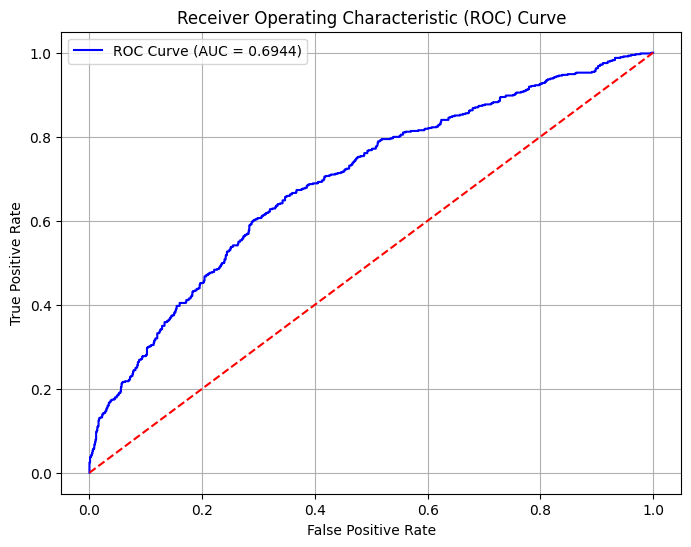

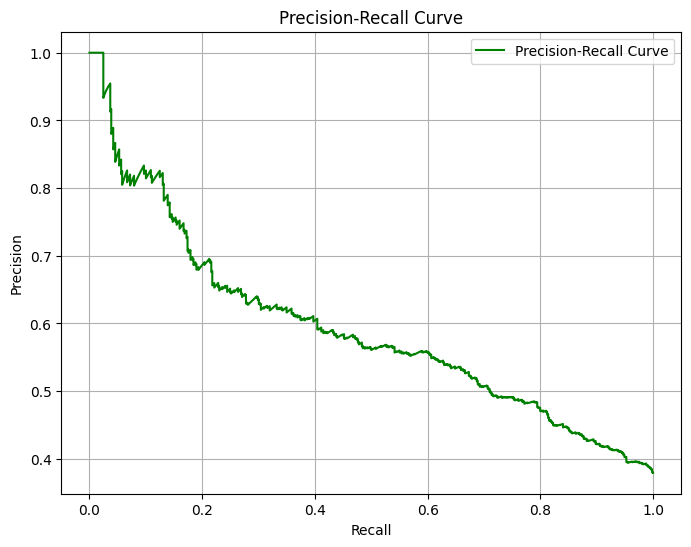

In [43]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
)


# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [44]:
print("Available keys in history.history:", history.history.keys())

Available keys in history.history: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


In [45]:
# Save the model after training
model.save('final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
